# UAS

In [1]:
pip install pymupdf4llm nltk networkx matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


--- 1. Mengekstrak teks dari Kopi.pdf ---
Berhasil mengekstrak 18015 karakter.

--- 2. Preprocessing & Pembuatan Bigram (1 Token & 2 Kata) ---
Total token (Unigram + Bigram) siap diproses: 2773
Contoh token dalam satu kalimat (Unigram & Bigram dicampur):
['volume', 'volume nomor', 'nomor', 'nomor juni', 'juni', 'juni analisis', 'analisis', 'analisis mutu', 'mutu', 'mutu kopi']

--- 3. Membangun Graph dari Co-occurrence Matrix ---
Graph terbentuk: 1293 node, 5291 edge.

--- 4. Menghitung Centrality Measures ---

=== TOP 20 KATA PENTING (KEYWORD EXTRACTION) ===
               PageRank    Degree  Betweenness  Closeness
kopi           0.028769  0.219040     0.390969   0.446015
honey          0.014324  0.082043     0.067437   0.376860
kadar          0.012889  0.090557     0.072060   0.374868
arabika        0.007405  0.051858     0.053553   0.365316
biji           0.007176  0.058824     0.041320   0.364898
kopi arabika   0.006925  0.043344     0.020240   0.369977
biji kopi      0.006276  0.0

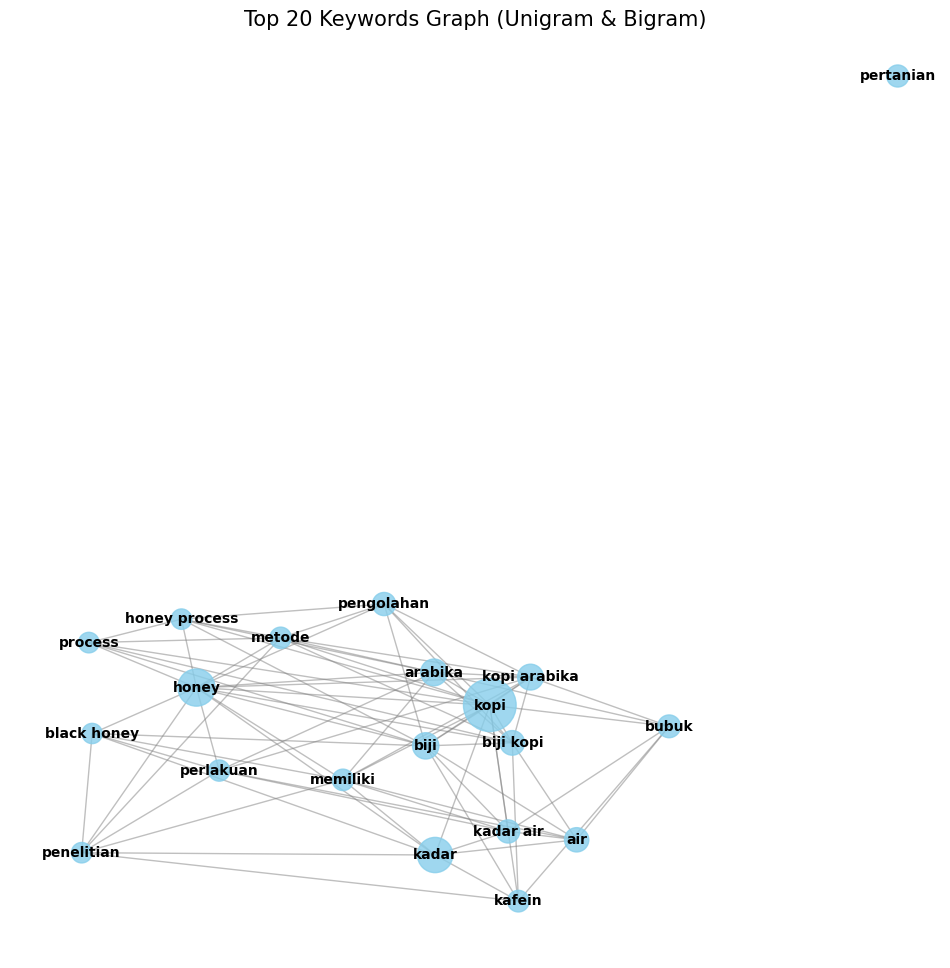

In [5]:
import fitz  # PyMuPDF
import nltk
import networkx as nx
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import pymupdf4llm
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict

# --- Konfigurasi Awal ---
# Mengunduh resource NLTK
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')
except:
    print("NLTK data mungkin sudah terinstall atau ada masalah koneksi.")

def main():
    # Ganti dengan nama file PDF Anda yang sebenarnya
    pdf_path = "Kopi.pdf"

    # Cek apakah file ada (untuk menghindari error di contoh ini jika file tidak diupload)
    import os
    if not os.path.exists(pdf_path):
        print(f"File {pdf_path} tidak ditemukan. Pastikan Anda mengunggah file PDF.")
        # Membuat file dummy untuk demonstrasi jika PDF tidak ada
        with open("dummy.pdf", "w") as f: f.write("dummy")
        # (Bagian ini hanya fallback, kode akan error di extract jika file asli rusak/tidak ada)
        return

    # ==========================================
    # TAHAP 1: Ekstrak Text dari PDF
    # ==========================================
    print(f"--- 1. Mengekstrak teks dari {pdf_path} ---")
    text_content = extract_text_from_pdf(pdf_path)
    print(f"Berhasil mengekstrak {len(text_content)} karakter.")

    # ==========================================
    # TAHAP 2: Preprocessing & Bigram Generation
    # ==========================================
    print("\n--- 2. Preprocessing & Pembuatan Bigram (1 Token & 2 Kata) ---")
    # Fungsi ini akan mengembalikan list token yang berisi Unigram DAN Bigram
    sequences_of_tokens = preprocess_text_with_ngrams(text_content)

    total_tokens = sum(len(seq) for seq in sequences_of_tokens)
    print(f"Total token (Unigram + Bigram) siap diproses: {total_tokens}")
    print("Contoh token dalam satu kalimat (Unigram & Bigram dicampur):")
    if sequences_of_tokens:
        print(sequences_of_tokens[0][:10]) # Tampilkan 10 token pertama

    # ==========================================
    # TAHAP 3: Membangun Graph (Co-occurrence)
    # ==========================================
    print("\n--- 3. Membangun Graph dari Co-occurrence Matrix ---")
    # Window size 3 cukup baik untuk menangkap hubungan antar bigram dan unigram yang berdekatan
    G = build_graph(sequences_of_tokens, window_size=3)
    print(f"Graph terbentuk: {G.number_of_nodes()} node, {G.number_of_edges()} edge.")

    # ==========================================
    # TAHAP 4: Perhitungan Centrality (PageRank dll)
    # ==========================================
    print("\n--- 4. Menghitung Centrality Measures ---")
    # Menghitung 4 jenis centrality
    pagerank = nx.pagerank(G, weight='weight')
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    closeness = nx.closeness_centrality(G)

    # Menggabungkan hasil ke dalam DataFrame
    nodes = list(G.nodes())
    data = {
        'PageRank': [pagerank[n] for n in nodes],
        'Degree': [degree[n] for n in nodes],
        'Betweenness': [betweenness[n] for n in nodes],
        'Closeness': [closeness[n] for n in nodes]
    }
    df_results = pd.DataFrame(data, index=nodes)

    # Mengambil Top 20 Kata Penting berdasarkan PageRank
    top_20 = df_results.sort_values(by='PageRank', ascending=False).head(20)

    print("\n=== TOP 20 KATA PENTING (KEYWORD EXTRACTION) ===")
    print(top_20)

    # ==========================================
    # TAHAP 5: Visualisasi
    # ==========================================
    visualize_graph(G, top_nodes=20)


# --- Fungsi Pendukung ---

def extract_text_from_pdf(filepath):
    """Ekstrak teks mentah dari PDF."""
    try:
        doc = fitz.open(filepath)
        text = pymupdf4llm.to_markdown(doc)
        doc.close()
        return text
    except Exception as e:
        print(f"Error membaca PDF: {e}")
        return ""

def preprocess_text_with_ngrams(text):
    """
    Membersihkan teks, membuat Unigram dan Bigram, lalu menggabungkannya.
    """
    sentences = sent_tokenize(text)
    # Gabungan stopwords
    stop_words = set(stopwords.words('indonesian') + stopwords.words('english'))

    processed_sequences = []

    for sentence in sentences:
        # 1. Bersihkan: Hanya huruf a-z, lowercase. Hapus angka/karakter aneh.
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence).lower()

        # 2. Tokenisasi dasar
        tokens = word_tokenize(sentence)

        # 3. Filter stopwords dan kata pendek (<3 huruf)
        filtered = [w for w in tokens if w not in stop_words and len(w) > 2]

        if not filtered:
            continue

        # 4. Buat sequence campuran (Unigram + Bigram)
        # Strategi: Interleaving [kata1, kata1_kata2, kata2, kata2_kata3, kata3...]
        # Ini menjaga alur kalimat sehingga co-occurrence tetap valid.
        interleaved = []
        for i in range(len(filtered)):
            # Tambahkan Unigram (1 kata)
            interleaved.append(filtered[i])

            # Tambahkan Bigram (2 kata) jika bukan kata terakhir
            if i < len(filtered) - 1:
                bigram = f"{filtered[i]} {filtered[i+1]}"
                interleaved.append(bigram)

        processed_sequences.append(interleaved)

    return processed_sequences

def build_graph(sequences, window_size=3):
    """Membangun graph dari list token (yang berisi unigram & bigram)."""
    d = defaultdict(int)

    for seq in sequences:
        # Sliding window
        for i in range(len(seq)):
            for j in range(1, window_size + 1):
                if i + j < len(seq):
                    u = seq[i]
                    v = seq[i+j]

                    if u == v: continue

                    # Sort agar tidak ada duplikasi arah (Undirected)
                    pair = tuple(sorted((u, v)))
                    d[pair] += 1

    G = nx.Graph()
    for (u, v), w in d.items():
        G.add_edge(u, v, weight=w)

    return G

def visualize_graph(G, top_nodes=50):
    """Visualisasi Top N nodes berdasarkan PageRank."""
    if G.number_of_nodes() == 0:
        return

    plt.figure(figsize=(12, 12))

    # Ambil subgraph hanya untuk top nodes agar visualisasi tidak ruwet
    pr = nx.pagerank(G, weight='weight')
    top_nodes_list = sorted(pr, key=pr.get, reverse=True)[:top_nodes]
    H = G.subgraph(top_nodes_list)

    pos = nx.spring_layout(H, k=0.5, seed=42)

    # Ukuran node berdasarkan PageRank
    node_sizes = [pr[n] * 50000 for n in H.nodes()]

    nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)
    nx.draw_networkx_edges(H, pos, width=1.0, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(H, pos, font_size=10, font_weight='bold')

    plt.title(f"Top {top_nodes} Keywords Graph (Unigram & Bigram)", fontsize=15)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


--- 1. Mengekstrak teks ---

--- 2. Preprocessing & Bigram ---

--- 3. Membangun Graph ---
Graph: 1293 node, 5291 edge.

--- 4. Menghitung Multi-Centrality ---

--- Perbandingan Top 20 per Metode ---
PageRank   : ['kopi', 'honey', 'kadar', 'arabika', 'biji', 'kopi arabika', 'biji kopi', 'air', 'kadar air', 'pengolahan', 'bubuk', 'pertanian', 'kafein', 'memiliki', 'metode', 'perlakuan', 'process', 'honey process', 'penelitian', 'black honey']
Degree     : ['kopi', 'kadar', 'honey', 'biji', 'arabika', 'pengolahan', 'biji kopi', 'air', 'kafein', 'penelitian', 'kopi arabika', 'memiliki', 'kadar air', 'hasil', 'bubuk', 'perlakuan', 'metode', 'pertanian', 'process', 'dibandingkan']
Betweenness: ['kopi', 'hasil', 'pertanian', 'kadar', 'honey', 'arabika', 'penelitian', 'biji', 'kafein', 'metode', 'process', 'mineral', 'kualitas', 'biji kopi', 'produk', 'industri', 'berdasarkan', 'meningkatkan', 'pengolahan', 'asam']
Closeness  : ['kopi', 'honey', 'kadar', 'kopi arabika', 'biji kopi', 'arabika'

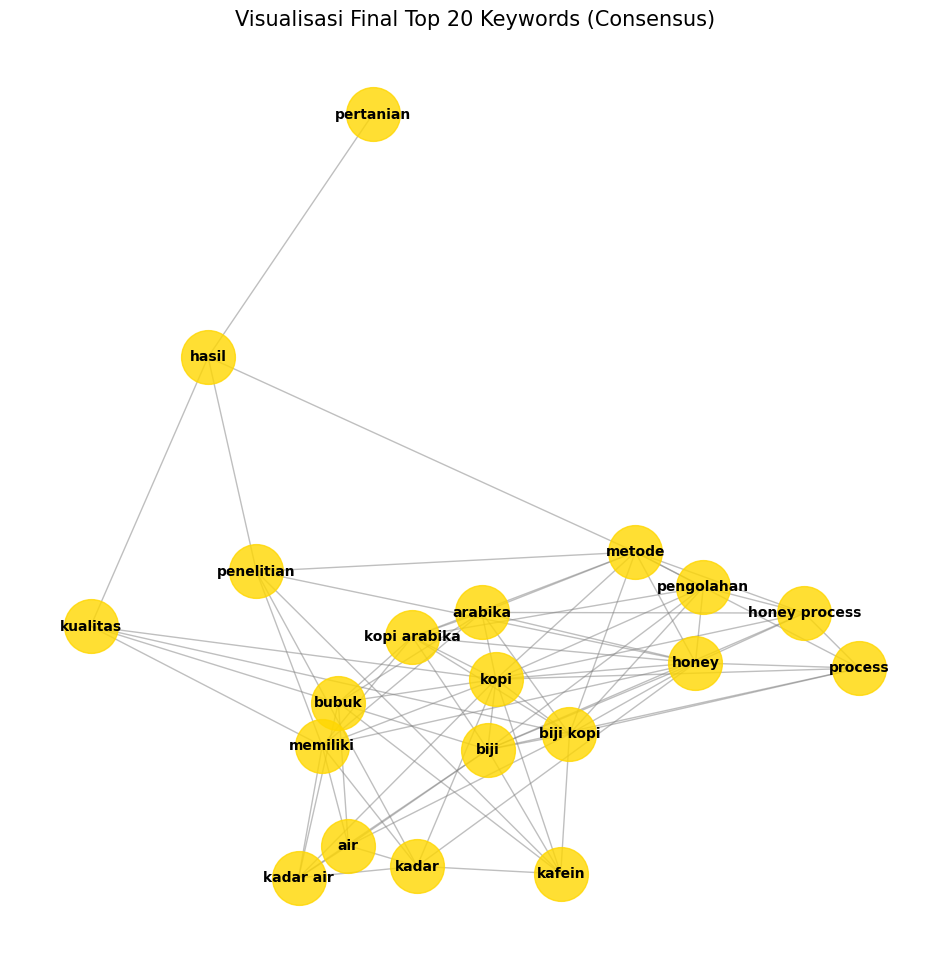

In [4]:
import fitz  # PyMuPDF
import nltk
import networkx as nx
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import pymupdf4llm
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict

# --- Konfigurasi Awal ---
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')
except:
    print("NLTK data mungkin sudah terinstall.")

def main():
    # Ganti dengan nama file PDF Anda
    pdf_path = "Kopi.pdf"

    # Cek file (Dummy logic)
    import os
    if not os.path.exists(pdf_path):
        print(f"File {pdf_path} tidak ditemukan. Membuat dummy file untuk demo.")
        with open("dummy.pdf", "w") as f: f.write("dummy")
        # Code akan lanjut tapi extract mungkin gagal jika ini real run tanpa file

    # 1. Ekstrak
    print(f"--- 1. Mengekstrak teks ---")
    text_content = extract_text_from_pdf(pdf_path)

    if not text_content: # Fallback jika PDF kosong/gagal baca
        print("Gagal baca PDF atau kosong.")
        return

    # 2. Preprocessing & Bigram
    print("\n--- 2. Preprocessing & Bigram ---")
    sequences = preprocess_text_with_ngrams(text_content)

    # 3. Build Graph
    print("\n--- 3. Membangun Graph ---")
    G = build_graph(sequences, window_size=3)
    print(f"Graph: {G.number_of_nodes()} node, {G.number_of_edges()} edge.")

    # 4. Hitung Semua Centrality
    print("\n--- 4. Menghitung Multi-Centrality ---")
    pagerank = nx.pagerank(G, weight='weight')
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    closeness = nx.closeness_centrality(G)

    # 5. Ambil Top 20 Masing-Masing
    top_pr = get_top_n(pagerank, 20)
    top_deg = get_top_n(degree, 20)
    top_bet = get_top_n(betweenness, 20)
    top_clo = get_top_n(closeness, 20)

    # Tampilkan perbandingan sekilas
    print("\n--- Perbandingan Top 20 per Metode ---")
    print(f"PageRank   : {top_pr[:20]}")
    print(f"Degree     : {top_deg[:20]}")
    print(f"Betweenness: {top_bet[:20]}")
    print(f"Closeness  : {top_clo[:20]}")

    # 6. Ringkas Jadi Satu (Consensus Scoring)
    print("\n--- 5. Meringkas Hasil (Consensus Ranking) ---")
    # Logika: Jika sebuah kata ada di rank 1 sebuah list, dapat poin 20. Rank 20 dapat poin 1.
    # Skor dijumlah dari ke-4 list.

    final_top_20 = calculate_consensus(top_pr, top_deg, top_bet, top_clo)

    # Buat DataFrame untuk tampilan rapi
    df_final = pd.DataFrame(final_top_20, columns=['Keyword', 'Consensus Score'])

    print("\n=== FINAL TOP 20 KEYWORDS (GABUNGAN) ===")
    print(df_final)

    # Visualisasi
    visualize_graph(G, [x[0] for x in final_top_20])

# --- Fungsi Pendukung ---

def extract_text_from_pdf(filepath):
    try:
        doc = fitz.open(filepath)
        text = pymupdf4llm.to_markdown(doc)
        doc.close()
        return text
    except:
        return ""

def preprocess_text_with_ngrams(text):
    sentences = sent_tokenize(text)
    stop_words = set(stopwords.words('indonesian') + stopwords.words('english'))
    processed_sequences = []

    for sentence in sentences:
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence).lower()
        tokens = word_tokenize(sentence)
        filtered = [w for w in tokens if w not in stop_words and len(w) > 2]

        if not filtered: continue

        interleaved = []
        for i in range(len(filtered)):
            interleaved.append(filtered[i])
            if i < len(filtered) - 1:
                interleaved.append(f"{filtered[i]} {filtered[i+1]}")
        processed_sequences.append(interleaved)
    return processed_sequences

def build_graph(sequences, window_size=3):
    d = defaultdict(int)
    for seq in sequences:
        for i in range(len(seq)):
            for j in range(1, window_size + 1):
                if i + j < len(seq):
                    u, v = seq[i], seq[i+j]
                    if u == v: continue
                    d[tuple(sorted((u, v)))] += 1
    G = nx.Graph()
    for (u, v), w in d.items():
        G.add_edge(u, v, weight=w)
    return G

def get_top_n(metric_dict, n=20):
    """Mengembalikan list [kata] teratas."""
    sorted_items = sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)
    return [item[0] for item in sorted_items[:n]]

def calculate_consensus(list1, list2, list3, list4):
    """
    Menggabungkan 4 list ranking menggunakan sistem poin.
    Rank 1 = 20 poin, Rank 20 = 1 poin.
    """
    scores = defaultdict(int)
    lists = [list1, list2, list3, list4]

    for lst in lists:
        for rank, word in enumerate(lst):
            # Poin = (Panjang List - Rank saat ini).
            # Jika list isi 20, rank 0 (pertama) dapat 20 poin.
            points = len(lst) - rank
            scores[word] += points

    # Urutkan berdasarkan total skor tertinggi
    final_ranking = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return final_ranking[:20]

def visualize_graph(G, top_keywords):
    if not top_keywords: return
    plt.figure(figsize=(12, 12))

    # Ambil subgraph hanya node-node juara
    H = G.subgraph(top_keywords)

    if H.number_of_nodes() > 0:
        pos = nx.spring_layout(H, k=0.8, seed=42)
        nx.draw_networkx_nodes(H, pos, node_size=1500, node_color='gold', alpha=0.8)
        nx.draw_networkx_edges(H, pos, width=1.0, alpha=0.5, edge_color='gray')
        nx.draw_networkx_labels(H, pos, font_size=10, font_weight='bold')
        plt.title("Visualisasi Final Top 20 Keywords (Consensus)", fontsize=15)
        plt.axis('off')
        plt.show()
    else:
        print("Tidak ada node untuk divisualisasikan.")

if __name__ == "__main__":
    main()

Link Aplikasi Web
https://huggingface.co/spaces/Umar22108/PPW-UAS